In [ ]:
from zipfile import ZipFile
import glob
from skimage.io import imread
from skimage.color import gray2rgb
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
dataset_path = '/content/drive/MyDrive/CSE428_LAB/Project/Group_2.zip'
dataset_path = '/content/drive/MyDrive/Group_2.zip'
#dataset_path = '/content/drive/MyDrive/CSE428_LAB/Project/Group_2.zip'
with ZipFile(dataset_path, 'r') as zip:
  zip.extractall()

In [ ]:
train_data_dir = '/content/Group_2/train'
test_data_dir = '/content/Group_2/test'


img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)



test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    batch_size=batch_size,
    class_mode='categorical'
)

true_labels = test_generator.classes

Found 2164 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])



# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Define the file path for saving the best model
checkpoint_filepath = 'inceptionv3_best_model.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Change to 'val_loss' if you want to save based on validation loss
    save_best_only=True,
    mode='max',  # Change to 'min' if you are monitoring validation loss
    verbose=1)

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)


# Load the best model based on validation accuracy
best_model = load_model(checkpoint_filepath)
model.summary()

Epoch 1/60
68/68 [==============================] - ETA: 0s - loss: 1.1501 - accuracy: 0.5684
Epoch 1: val_accuracy improved from -inf to 0.85600, saving model to inceptionv3_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 38s 468ms/step - loss: 1.1501 - accuracy: 0.5684 - val_loss: 0.4061 - val_accuracy: 0.8560
Epoch 2/60
68/68 [==============================] - ETA: 0s - loss: 0.7934 - accuracy: 0.6922
Epoch 2: val_accuracy improved from 0.85600 to 0.88000, saving model to inceptionv3_best_model.h5
68/68 [==============================] - 31s 453ms/step - loss: 0.7934 - accuracy: 0.6922 - val_loss: 0.3501 - val_accuracy: 0.8800
Epoch 3/60
68/68 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.7038
Epoch 3: val_accuracy did not improve from 0.88000
68/68 [==============================] - 30s 430ms/step - loss: 0.7634 - accuracy: 0.7038 - val_loss: 0.3601 - val_accuracy: 0.8680
Epoch 4/60
68/68 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.7079
Epoch 4: val_accuracy improved from 0.88000 to 0.90800, saving model to inceptionv3_best_model.h5
68/68 [==============================] - 30s 444ms/step - loss: 0.7183 - ac

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_generator)

# # You may want to convert the predictions to class labels if needed
predicted_classes = tf.argmax(predictions, axis=1)

# # Evaluate the accuracy by comparing with true labels
# y_test = test_generator.classes
print(classification_report(true_labels, predicted_classes, digits = 3))

8/8 [==============================] - 1s 150ms/step
              precision    recall  f1-score   support

           0      0.224     0.220     0.222        50
           1      0.212     0.220     0.216        50
           2      0.240     0.240     0.240        50
           3      0.146     0.140     0.143        50
           4      0.235     0.240     0.238        50

    accuracy                          0.212       250
   macro avg      0.211     0.212     0.212       250
weighted avg      0.211     0.212     0.212       250



In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

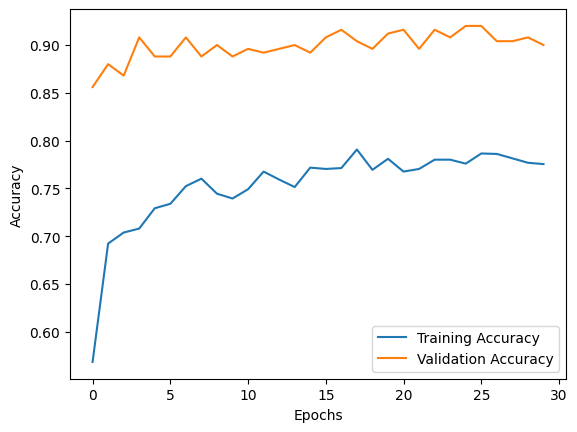

In [ ]:
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Best Model Test Accuracy: {test_accuracy * 100:.2f}%')

8/8 [==============================] - 2s 97ms/step - loss: 0.2740 - accuracy: 0.9200
Best Model Test Accuracy: 92.00%


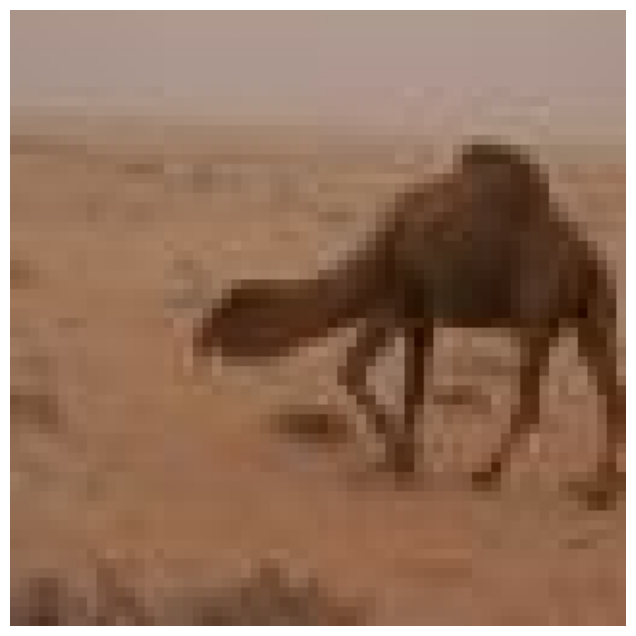

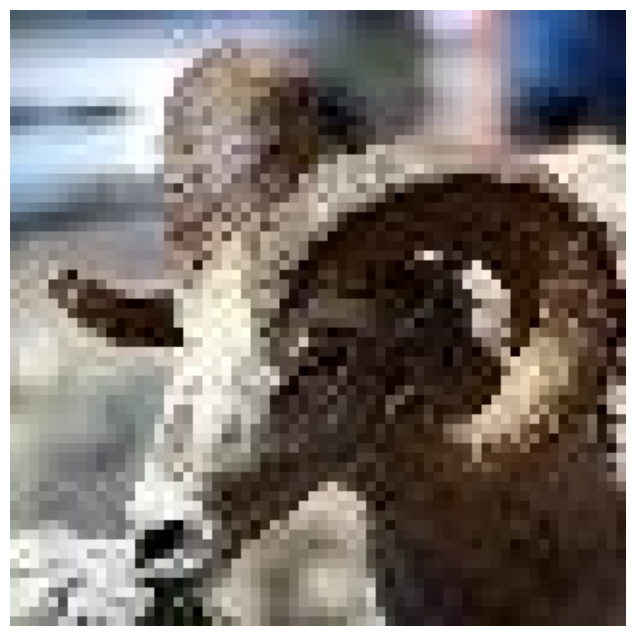

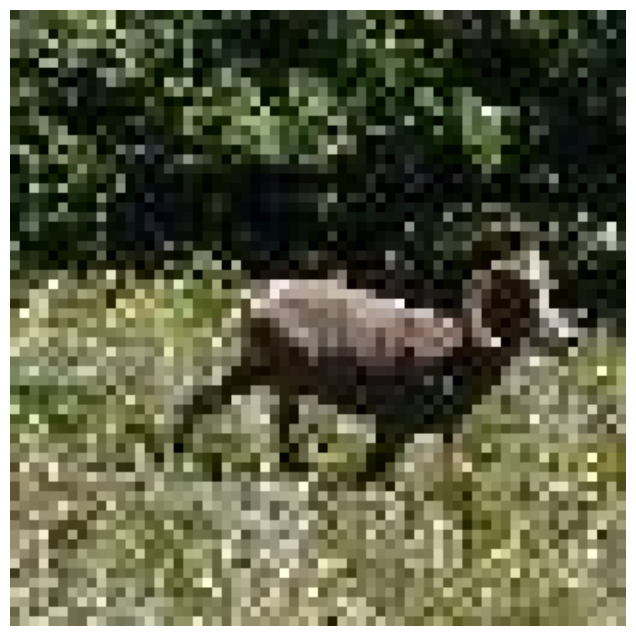

In [ ]:
# Get true labels using class indices from the generator



# Find indices of misclassified images
misclassified_indices = np.where(predicted_classes != true_labels)[0]

# Display the first few misclassified images
num_misclassified_to_display = 3
for i in range(min(num_misclassified_to_display, len(misclassified_indices))):
    index = misclassified_indices[i]
    # Load and display the misclassified image
    img_array, true_label = test_generator[index]
    # img_array = img_array / 255.0  # Rescale to [0, 1]

    # Get the predicted label
    # predicted_label = test_generator.class_indices[predicted_classes[index]]

    plt.figure(figsize=(8, 8))
    plt.imshow(img_array[0])
    # plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()
